In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
import os

In [2]:
file_path = r"data\ML EIS\values obtained by Nova2.1 integrited fitting.xlsx"
res = pd.read_excel(file_path).iloc[:, [0, 1]]  

for i in range(1, 31):
    file_name = f"sample {i}.xlsx"
    file_path = os.path.join('data\ML EIS', file_name)

    df = pd.read_excel(file_path).iloc[:, [2, 3]]    
    df_name = f"df_{i}"

    globals()[df_name] = pd.DataFrame({'x': df.iloc[:, 0],
                                       'y': df.iloc[:, 1],})


In [3]:
def get_plot(df):
    df.plot(x='x', y='y', kind='scatter', figsize=(6, 3))
    plt.ylabel('y')
    plt.show()

# for j in range(1,31):
#     get_plot(globals()[f"df_{j}"])

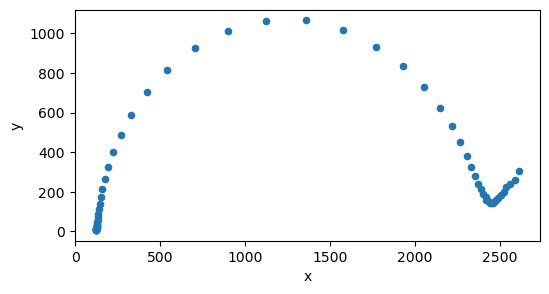

In [4]:
get_plot(df_7)

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
def zero_grad(df, tol=1e-5, index=False, shift=8):
    # Compute gradient
    dx = df['x'].iloc[1] - df['x'].iloc[0]
    dy = np.gradient(df['y'], dx)

    # Find where first derivative is approximately zero (remove any from start of dataset)
    zero_indices = np.where(np.abs(dy) < tol)[0]
    zero_indices = [idx for idx in zero_indices if idx > 25]

    # Find instances of zero gradient (x,y)
    candidates = [(df['x'].iloc[idx], df['y'].iloc[idx]) for idx in zero_indices]

    # Recursively increase tolerance if no candidates found
    if not candidates and tol < 10:
        return zero_grad(df, tol * 1.2, index)
    
    # Once point found, either return index or value
    else:
        if index:
            return zero_indices[0] - shift
        else:
            return candidates[0] if candidates else None


# Define the equation of a circle for fitting
def circle_equation(params, x, y):
    xc, yc, R = params
    return (x - xc)**2 + (y - yc)**2 - R**2


# Define the objective function for the optimization
def objective_function(params, x, y):
    return np.sum(circle_equation(params, x, y)**2)


def get_impedance_eq(df, graph=False):
    # Use zero_grad() to split dataset to circular region
    z_cross = zero_grad(df, tol=1e-7, index=True)
    x_data = df['x'].iloc[:z_cross]
    y_data = df['y'].iloc[:z_cross]

    # Initial guess for parameters (center and radius) + minimization
    params_guess = [np.mean(x_data), np.mean(y_data), (max(x_data) - min(x_data)) / 2]
    result = minimize(objective_function, params_guess, args=(x_data, y_data))

    # Extract optimized parameters
    xc_opt, yc_opt, R_opt = result.x

    if graph: 
        # Plot the data and the fitted circle
        plt.figure(figsize=(6, 3))
        plt.scatter(x_data, y_data, label='Data')
        circle = plt.Circle((xc_opt, yc_opt), R_opt, color='r', fill=False, linestyle='--', label='Fitted Circle')
        plt.gca().add_artist(circle)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Data and Fitted Circle')
        plt.legend()
        plt.autoscale()
        plt.grid(True)
        plt.axis('equal')  # Equal aspect ratio
        plt.show()
    #print("Optimized parameters (xc, yc, R):", [xc_opt, yc_opt, R_opt])
    #print(f"Impedance: {R_opt*2:.3g} Ω")
    return(R_opt*2)

def get_final_impedance(df, graph=False):
    res = get_impedance_eq(df)
    if res > 1000:
        z_cross = -24
        x_data = df['x'].iloc[:z_cross]
        y_data = df['y'].iloc[:z_cross]

        # Initial guess for parameters (center and radius) + minimization
        params_guess = [np.mean(x_data), np.mean(y_data), (max(x_data) - min(x_data)) / 2]
        result = minimize(objective_function, params_guess, args=(x_data, y_data))

        # Extract optimized parameters
        xc_opt, yc_opt, R_opt = result.x
        if graph: 
            # Plot the data and the fitted circle
            plt.figure(figsize=(6, 3))
            plt.scatter(x_data, y_data, label='Data')
            circle = plt.Circle((xc_opt, yc_opt), R_opt, color='r', fill=False, linestyle='--', label='Fitted Circle')
            plt.gca().add_artist(circle)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Data and Fitted Circle')
            plt.legend()
            plt.autoscale()
            plt.grid(True)
            plt.axis('equal')  # Equal aspect ratio
            plt.show()
        #print("Optimized parameters (xc, yc, R):", [xc_opt, yc_opt, R_opt])
        #print(f"Impedance: {R_opt*2:.3g} Ω")
        return(R_opt*2)
    
    else:
        return(res)

Sample 1


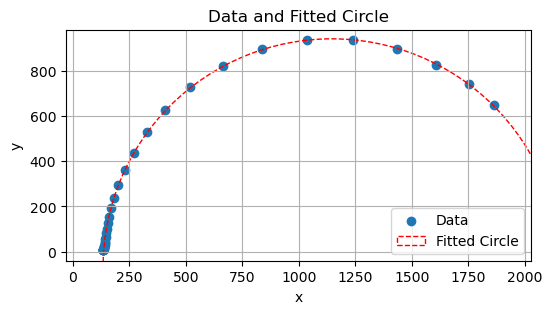

Sample 2


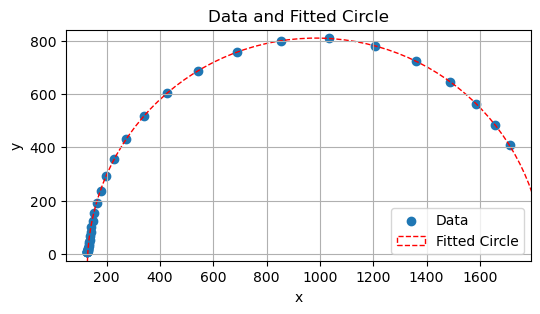

Sample 3


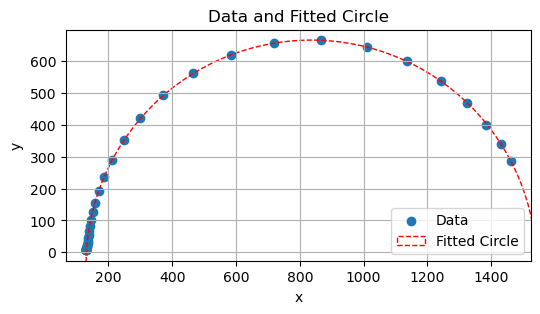

Sample 4


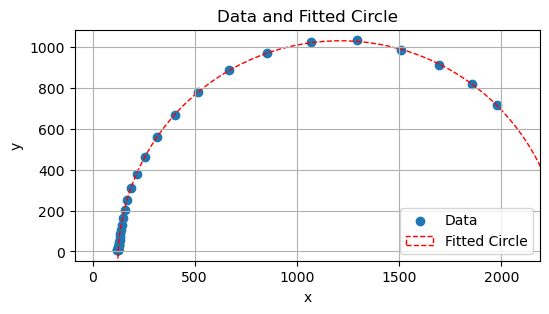

Sample 5


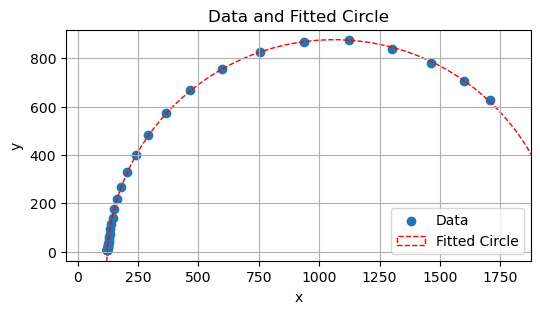

Sample 6


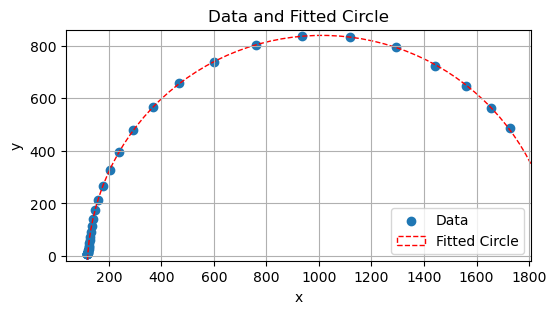

Sample 7


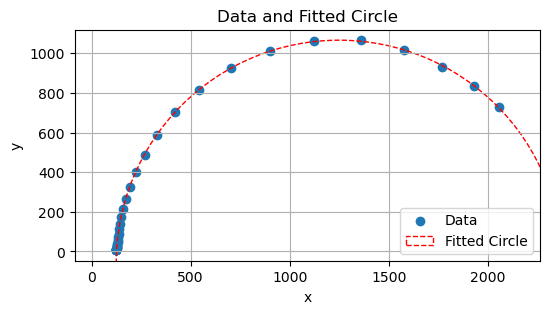

Sample 8


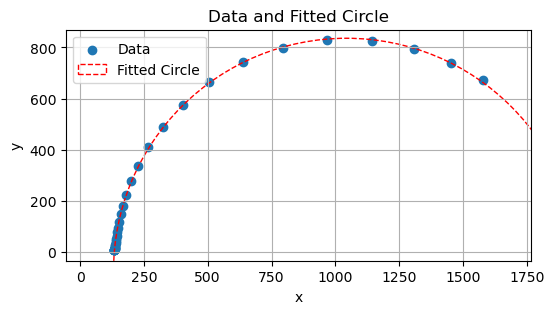

Sample 9


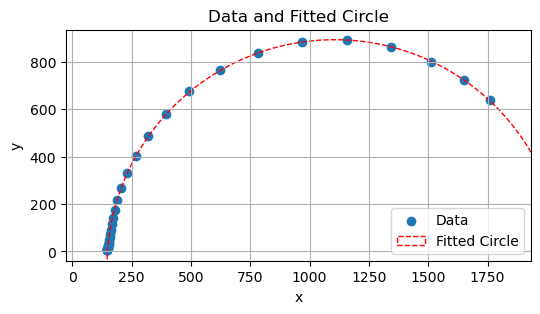

Sample 10


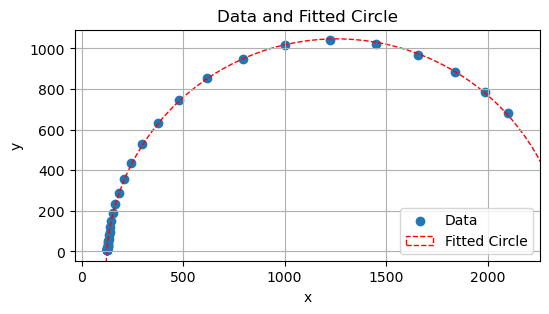

Sample 11


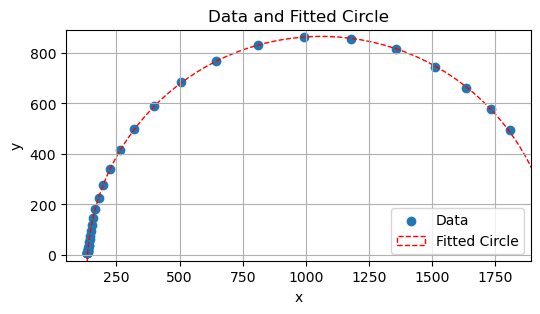

Sample 12


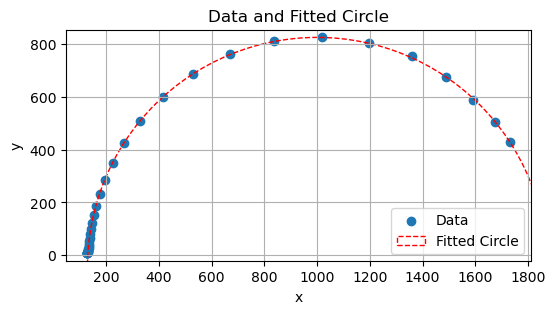

Sample 13


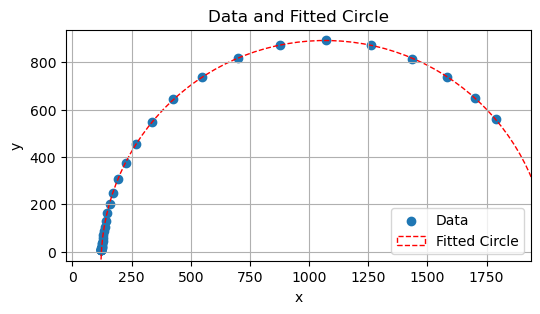

Sample 14


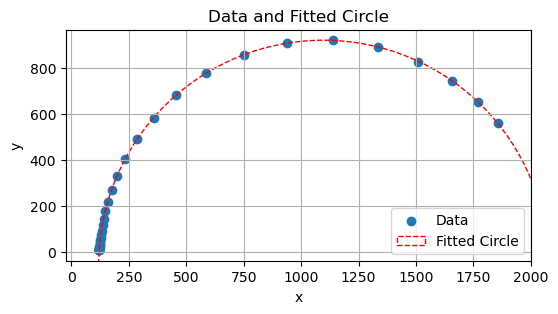

Sample 15


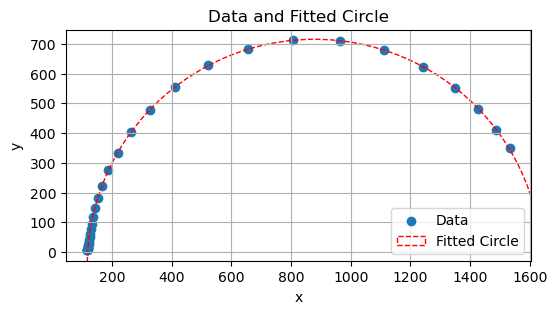

Sample 16
Sample 17
Sample 18
Sample 19
Sample 20
Sample 21
Sample 22
Sample 23
Sample 24
Sample 25
Sample 26
Sample 27
Sample 28
Sample 29
Sample 30
1.6012804844720145


In [7]:
imp_calc = []
for k in range(1,31):
    print(f"Sample {k}")
    holder = get_final_impedance(globals()[f"df_{k}"], True)
    imp_calc.append(holder)

res['Calc Impedance'] = imp_calc
res['Abs Error'] = (res['Impedance(Ohms)'] - res['Calc Impedance'])
res['Outlier'] = abs(res['Abs Error']) > 30
res['Percentage Error'] = ((res['Impedance(Ohms)'] - res['Calc Impedance'])/res['Impedance(Ohms)']) *100
MAE = sum(res['Abs Error'])/30
print(MAE)

In [15]:
res.drop(['Outlier'], axis=1)

,Sample No.,Impedance(Ohms),Calc Impedance,Abs Error,Percentage Error
0,1,2030,2023.381388,6.618612,0.326040
1,2,1710,1714.552404,-4.552404,-0.266222
2,3,1400,1411.362926,-11.362926,-0.811638
3,4,2170,2174.373864,-4.373864,-0.201561
4,5,1900,1880.585626,19.414374,1.021809
5,6,1790,1785.228134,4.771866,0.266585
6,7,2240,2248.940183,-8.940183,-0.399115
7,8,1870,1825.201490,44.798510,2.395642
8,9,1930,1919.228059,10.771941,0.558132
9,10,2300,2270.643588,29.356412,1.276366


In [14]:
res.head()

,Sample No.,Impedance(Ohms),Calc Impedance,Abs Error,Outlier,Percentage Error
0,1,2030,2023.381388,6.618612,False,0.326040
1,2,1710,1714.552404,-4.552404,False,-0.266222
2,3,1400,1411.362926,-11.362926,False,-0.811638
3,4,2170,2174.373864,-4.373864,False,-0.201561
4,5,1900,1880.585626,19.414374,False,1.021809


In [9]:
res['Percentage Error'].abs().mean()

0.7214131751814101